- references
    - https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model
    - InstructGPT:
        - https://openai.com/index/instruction-following/
        - https://arxiv.org/abs/2203.02155

In [1]:
from IPython.display import Image

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

### instructGPT

In [3]:
Image(url='https://miro.medium.com/v2/resize:fit:1100/format:webp/1*R8D4ixMVWxSOyvvIoc_T-w.png', width=500)

$$
\text{loss}(\theta) = -\frac{1}{\binom{K}{2}} \mathbb{E}_{(x, y_w, y_l) \sim D} \left[ \log \left( \sigma \left( r_\theta(x, y_w) - r_\theta(x, y_l) \right) \right) \right]
$$

In [4]:
Image(url='https://images.ctfassets.net/kftzwdyauwt9/690sZjaYwbes9IMEgfyJ7O/f536896b496b13749518f53d4caaa713/Methods_Diagram_dark_mode.jpg?w=2048&q=80&fm=webp', width=600)

- D>C>A=B

In [5]:
Image(url='./imgs/quality-labels.png', width=500)

- 单个的标注（监督学习，直接回归 rating），rating 未必是全局唯一的，
    - labeler A 认为的 3分在 labeler B 的 4分或者2分，即 rating 的 scale 未必对所有的 labelers 都是适用的；
    - 李克特量表（Likert scale）
- reward model
    - 双输入，siamese network；

#### 损失函数的理解

#### 概率建模

$$
\begin{split}
\delta=r_w-r_l&=\log {odds}=\log \frac{p}{1-p}\\
&\Downarrow\\
p&=\frac{1}{1+\exp(-\delta)}=\sigma(\delta)\\
&\Downarrow\\
&-\log p=-\log\sigma(\delta)
\end{split}
$$

- log odds（对数赔率，赔率的对数）：$r_w-r_l=\log odds$
    - $p=p(y_w\gt y_l)$
    - 奖励差，表示人类更可能偏好响应1（$r_w$，$r_\text{chosen}$）而非响应2（$r_\ell$，$r_\text{rejected}$）的对数赔率。
- They use a cross-entropy loss, with the comparisons as labels—the difference in rewards represents the log odds that one response will be preferred to the other by a human labeler
    - 我们已经假定人类标注者更偏好响应1，设定真实标签 $y=1$；（如果人类更偏好响应2，设定 $y=0$）
    - 则交叉熵损失为 $-[y\log P+(1-y)\log (1-P)] = -\log P$
- 多数时候我们看到 log probability 的时候基本就是在计算交叉熵；

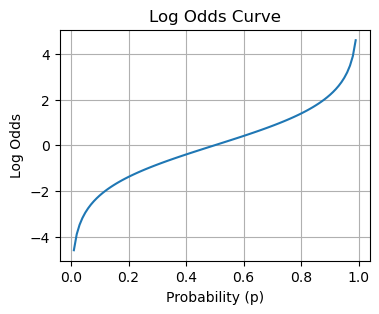

In [6]:
p = np.linspace(0.01, 0.99, 100)
log_odds = np.log(p / (1 - p))  # Calculate log odds

# Plotting the log odds curve
plt.figure(figsize=(4, 3))
plt.plot(p, log_odds)
plt.xlabel('Probability (p)')
plt.ylabel('Log Odds')
plt.title('Log Odds Curve')
plt.grid(True)

### multiple responses

$$
k=9
$$
- 可以很大的膨胀数据集的规模
    - batch size 64，k = 9
    - $\leq 64 \cdot \binom{9}{2}=2304$
- 这里取K=9，是考虑到人工标注的时候，很大一部分时间是花在读懂这个prompt。而读懂prompt和一两个答案之后，其它答案就理解的很快了。所以排序9个比排序4个所花的时间并不是增加了一倍。而且 $C_9^2=36,C_4^2=6$，等于额外开销不到一倍，而标注的数据多了6倍。
- 另外之前的工作不仅是 K=4 ，而且在标注的时候只标注最好的一个 ，这样就是4选1，这样只需要最大化最优答案的分数就行，所以容易过拟合。而这里采用的是 
 $C_k^2$ 个排序对，使得整个问题变得复杂一点，缓解了过拟合

In [7]:
import math
64 * math.comb(9, 2)

2304

### Bradley-Terry model

In [8]:
Image(url='https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F0605ace1-cc21-400a-941f-154a1faa103c_1600x1427.png', width=400)

#### gradient of loss

$$
\begin{split}
&\ell=-\log\sigma(\delta)\\
&\ell'=\sigma(\delta)-1
\end{split}
$$

- loss is proportional to the log odds that the first resp is greater than the second;

In [9]:
# `r1=r2` 时的 loss
-F.logsigmoid(torch.tensor(0.)), -np.log10(1/(1+np.exp(-0)))

(tensor(0.6931), 0.3010299956639812)

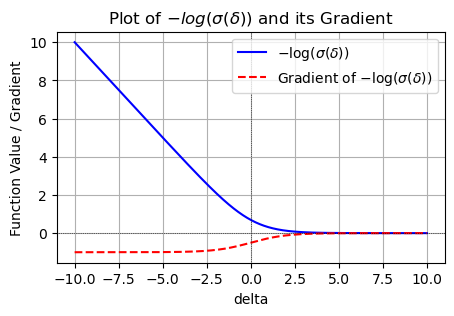

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define the delta range
delta = np.linspace(-10, 10, 1000)

# Define the function -log(sigma(delta)) and its gradient
sigma = 1 / (1 + np.exp(-delta))
neg_log_sigma = -np.log(sigma)
grad_neg_log_sigma = sigma-1  # derivative of -log(sigma(delta)) with respect to delta

# Plotting
plt.figure(figsize=(5, 3))
plt.plot(delta, neg_log_sigma, label='$-\log(\sigma(\delta))$', color='blue')
plt.plot(delta, grad_neg_log_sigma, label="Gradient of $-\log(\sigma(\delta))$", color='red', linestyle='--')

plt.axhline(0, color='black', linewidth=0.5, linestyle=':')
plt.axvline(0, color='black', linewidth=0.5, linestyle=':')

plt.title('Plot of $-log(\sigma(\delta))$ and its Gradient')
plt.xlabel('delta')
plt.ylabel('Function Value / Gradient')
plt.legend()
plt.grid(True)
plt.show()

- $\delta=r_1-r_2\geq 3$ 以后 loss 接近于0，且基本没有梯度了，；

In [16]:
-np.log(1/(1+np.exp(-1))), -np.log(1/(1+np.exp(-3))), -np.log(1/(1+np.exp(-(-6))))

(0.3132616875182228, 0.0485873515737419, 6.00247568513773)

In [15]:
1/(1+np.exp(-(-6)))

0.0024726231566347743